In [1]:
import numpy as np
import cv2 as cv


def detection(feature, source, sift, flann, cont=None):
    MIN_MATCH_COUNT = 10 
    kp1, des1 = sift.detectAndCompute(feature, None) 
    kp2, des2 = sift.detectAndCompute(source, None)

    matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)  # ?

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

        h, w = feature.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
        cont = [np.int32(dst)]
        source = cv.fillPoly(source, pts=cont, color=(255, 255, 255))
        return True, cont, source
    else:
        return False, cont, source


candy = cv.imread('candy_ghost.png', 0)
pumpkin = cv.imread('pampkin_ghost.png', 0)
scary = cv.imread('scary_ghost.png', 0)
image = cv.imread('lab7.png', -1)
ghosts = image.copy()

FLANN_INDEX_KDTREE = 1
sift = cv.SIFT_create()
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

for x in [candy, pumpkin, scary]:
    found = True
    while found:
        found, cont, ghosts = detection(x, ghosts, sift, flann)
        image = cv.polylines(image, cont, True, 255, 3, cv.LINE_AA)
    found = True
    while found:
        found, cont, ghosts = detection(cv.flip(x, 1), ghosts, sift, flann)
        image = cv.polylines(image, cont, True, 255, 3, cv.LINE_AA)

cv.imwrite('result.png', image)

True

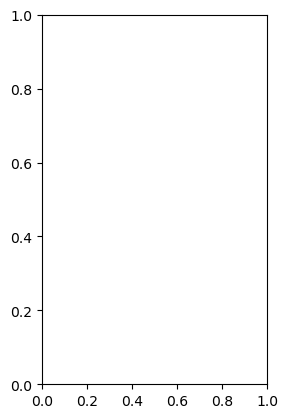

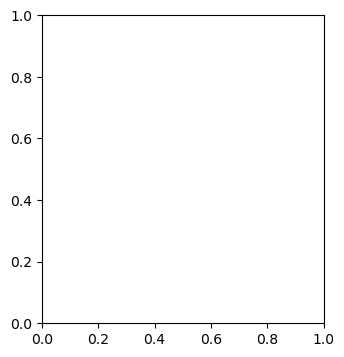

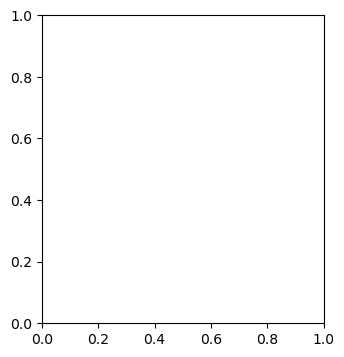

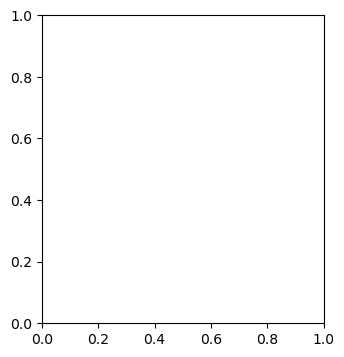

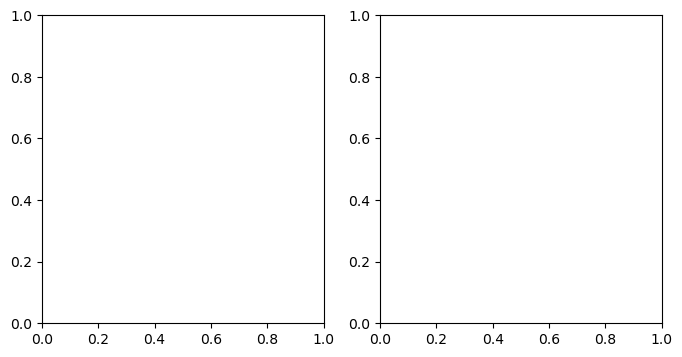

In [4]:
import os
import matplotlib.pyplot as plt
import keyboard
import numpy as np
import cv2
import random

def augmen_fun(a , img, lab, h1, h2, w1, w2, vis):
    if a==1:#поворот
        (h, w, d) = img.shape
        sh = (int(w), int(h))
        center = (int(w/2), int(h/2))
        rot_mat = cv2.getRotationMatrix2D(center, 30, 1.0)
        result = cv2.warpAffine(img, rot_mat,sh)
        (h, w, d) = lab.shape
        center = (int(w/2), int(h/2))
        sh = (int(w), int(h))
        rot_mat2 = cv2.getRotationMatrix2D(center, 30, 1.0)
        result2 = cv2.warpAffine(lab, rot_mat2, sh)
        vis[:h1, :w1, :3] = result
        vis[:h2, w1:w1+w2,:3] = result2
        cv2.imshow('1',vis)
        
    if a==2:#по горизонтали
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        vis[:h1, :w1, :3] = img[::-1]
        vis[:h2, w1:w1+w2,:3] = lab[::-1]
        cv2.imshow('2',vis)
        
    if a==3:#по вертикали
        plt.subplot(1, 2, 2)
        plt.subplot(1, 2, 2)
        vis[:h1, :w1, :3] = cv2.flip(img, 1)
        vis[:h2, w1:w1+w2,:3] = cv2.flip(lab, 1)
        cv2.imshow('3',vis)
        
    if a==4:#обрезание
        np.random.seed(43)
        bbox = np.random.randint(2, h1)
        bbox1 = np.random.randint(2, w1)
        bbox2 = np.random.randint(bbox, bbox+h1)
        bbox3 = np.random.randint(bbox1, bbox1+w1)
        result1 = img[bbox1:bbox1+bbox3, bbox:bbox+bbox2]
        result2 = lab[bbox1:bbox1+bbox3, bbox:bbox+bbox2]
        h1,w1 = result1.shape[:2]
        h2,w2 = result2.shape[:2]
        vis1 = np.zeros((max(h1, h2), w1+w2, 3), np.uint8)
        vis1[:h1, :w1, :3] = result1
        vis1[:h2, w1:w1+w2,:3] =result2
        cv2.imshow('4',vis1)

    if a == 5:#размытие
        alpha, betta = 0.5, 50
        result1 = alpha*img.astype(np.int32) + betta
        result1 = np.clip(result1, 0, 255).astype(np.uint8)
        result2 = alpha*img.astype(np.int32) + betta
        result2 = np.clip(result2, 0, 255).astype(np.uint8)
        vis[:h1, :w1, :3] = result1
        vis[:h2, w1:w1+w2,:3] = result2
        cv2.imshow('5',vis)

#main
path_image = "C:/Users/79132/images"
path_label = "C:/Users/79132/labels"

for i in os.listdir(path_image):
    os.chdir(path_image)
    img_op = cv2.imread(i)
    h1,w1 = img_op.shape[:2]
    os.chdir(path_label)
    label_op = cv2.imread(i)
    h2,w2= label_op.shape[:2]

    vis = np.zeros((max(h1, h2), w1+w2, 3), np.uint8)
    vis[:h1, :w1, :3] = img_op
    vis[:h2, w1:w1+w2,:3] = label_op
cv2.imshow('1', vis)

while(1):
    if cv2.waitKey(33) == ord('d'):
        a = random.randint(1,5)
        augmen_fun(a, img_op, label_op, h1, h2, w1, w2, vis)
    if cv2.waitKey(33) == ord('q'):
        break

cv2.destroyAllWindows()